# VQEのコード実装

In [1]:
%load_ext wurlitzer

In [2]:
import random
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
%matplotlib inline
import sys

from qulacs import QuantumState, QuantumCircuit, Observable, PauliOperator
from qulacs.gate import CNOT, RX, RY, RZ

import qulacsvis
from qulacsvis import circuit_drawer
'''
ここでは高い計算速度を期待してqulacsを利用している。
他に量子コンピュータに関するライブラリが豊富なフレームワークとしてQiskitがあるが、
そちらでもほとんど同じ内容のコードで実装ができる。
以下に従うことでインストールが可能。
Qulacs
http://docs.qulacs.org/ja/latest/intro/1_install.html
Qiskit
https://docs.quantum.ibm.com/guides/install-qiskit
'''

# Hamiltonian
### 横磁場Isingモデル
### $$ H = -J\sum_{n=0}^{N-2}Z_{n}Z_{n+1}-h\sum_{n=0}^{N-1}X_{n} $$
### 
### Heisenbergモデル
### $$ H = -J\sum_{n=0}^{N-1}(X_{n}X_{n+1}+Y_{n}Y_{n+1}+Z_{n}Z_{n+1}) $$

In [3]:
num_site = 8

In [15]:
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import numpy as np

'''
本コードではVQEの実行結果の精度を見るための解析的な解として
quspinによる厳密対角化の結果を利用している。
実行に際しては以下に従ってquspinのインストールが必要。
https://quspin.github.io/QuSpin/Installation.html
'''

n = num_site
j_coup = 1
h_ext = 3
basis = spin_basis_1d(n)

#実行したい物理モデルに合わせて以下の設定を切り替える。
### 横磁場Isingモデル
h_zz = [[-j_coup,  i , i+1] for i in range(n-1)]
h_x = [[-h_ext, i] for i in range(n)]
### static and dynamic lists
static = [["zz",h_zz],["x",h_x]]
dynamic=[]

#### Heisenbergモデル
#h_xx = [[-j_coup,  i , i+1] for i in range(n-1)]
#h_yy = [[-j_coup,  i , i+1] for i in range(n-1)]
#h_zz = [[-j_coup,  i , i+1] for i in range(n-1)]
#### static and dynamic lists
#static = [["xx",h_xx],["yy",h_yy],["zz",h_zz]]
#dynamic=[]

hamil = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,check_herm=False,check_pcon=False,check_symm=False)



### calculate full eigensystem
#energy, state = hamil.eigsh(k=1,which='SA')
energy, state = hamil.eigh()
energy_quspin_open = energy[0]
print(energy_quspin_open)

#energy_quspin_open = -3.124801557565161 # ED where n = 4
#if(n==8):
#    energy_quspin_open = -7.425225886771928
#elif(n==12):
#    energy_quspin_open = -12.545873695502673
#elif(n==16):
#    energy_quspin_open = -18.46946149483945

-24.586275728865992


##### ansatzやcost関数の定義

In [11]:
def ansatz_layer_hea(circuit, parameters, num_qubit):

    '''
    ansatzの構造
    ansatz_layer_heaでは繰り返し構造となっている1layerを作成
    make_ansatz_heaにてlayerを複数回繰り返してansatz全体を作成
    |0>---RX-RZ-・-------RX-RZ-・------RX-RZ-・-------
                |              |           |         
    |0>---RX-RZー+--・----RX-RZ-+--・---RX-RZ-+--・----
                    |              |            |    
    |0>---RX-RZ-・---+----RX-RZ-・--+---RX-RZ-・--+----
                |               |            |        
    |0>---RX-RZ-+--・------RX-RZ-+--・---RX-RZ-+--・---
                           :
                           :
    '''

    iparam = 0

    for i_qubit in range(num_qubit):
        circuit.add_gate(RX(i_qubit,parameters[iparam]))
        circuit.add_gate(RZ(i_qubit,parameters[iparam+1]))
        iparam += 2

    if num_qubit % 2 ==0:
        for i_qubit in range(0,num_qubit-1,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
        for i_qubit in range(1,num_qubit-2,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
    else:
        for i_qubit in range(0,num_qubit-2,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
        for i_qubit in range(1,num_qubit-1,2):
            circuit.add_gate(CNOT(i_qubit, i_qubit+1))
    

    return circuit

In [7]:
def make_ansatz_hea(parameters, num_qubit, num_params_layer, rep_layer):
    
    circuit = QuantumCircuit(num_qubit)
    iparam = 0

    ### repeat the layer
    for _ in range(rep_layer):
        circuit = ansatz_layer_hea(circuit=circuit, parameters=parameters[iparam:iparam+num_params_layer], num_qubit=num_qubit)
        iparam += num_params_layer
    
    return circuit

In [19]:
def cost_hea(parameters, num_qubit, num_params_layer, rep_layer, j_coup, h_ext):
    global list_cost_hea
    '''
    与えられたハイパーパラメータをもとにansatzを作成し
    observableという物理量に対する期待値を取得
    '''
    
    state = QuantumState(num_qubit)
    state.set_zero_state()

    circuit = make_ansatz_hea(parameters=parameters, num_qubit=num_qubit, num_params_layer=num_params_layer, rep_layer=rep_layer)
    circuit.update_quantum_state(state)

    #物理量の作成
    observable = Observable(num_qubit)

    #quspinのコードと同様、実行したい物理モデルにより以下を切り替える。
    ### 横磁場Isingモデル
    #H_{ZZ}
    for i in range(num_qubit-2):
        observable.add_operator(-j_coup, f"Z {i} Z {i+1}")
    #H_{X}
    for i in range(num_qubit-1):
        observable.add_operator(-h_ext, "X "+str(i))
    
    ### Heisenbergモデル
    ##H_{XX}
    #for i in range(0,num_qubit-1):
    #    observable.add_operator(-j_coup, f"X {i} X {i+1}")
    ##H_{YY}
    #for i in range(0,num_qubit-1):
    #    observable.add_operator(-j_coup, f"Y {i} Y {i+1}")
    ##H_{ZZ}
    #for i in range(num_qubit-1):
    #    observable.add_operator(-j_coup, f"Z {i} Z {i+1}")


    cost = observable.get_expectation_value(state)
    
    list_cost_hea.append(cost)
    
    return cost

num site : 8
num_params_layer : 16
num_params : 48
circuit depth : 12


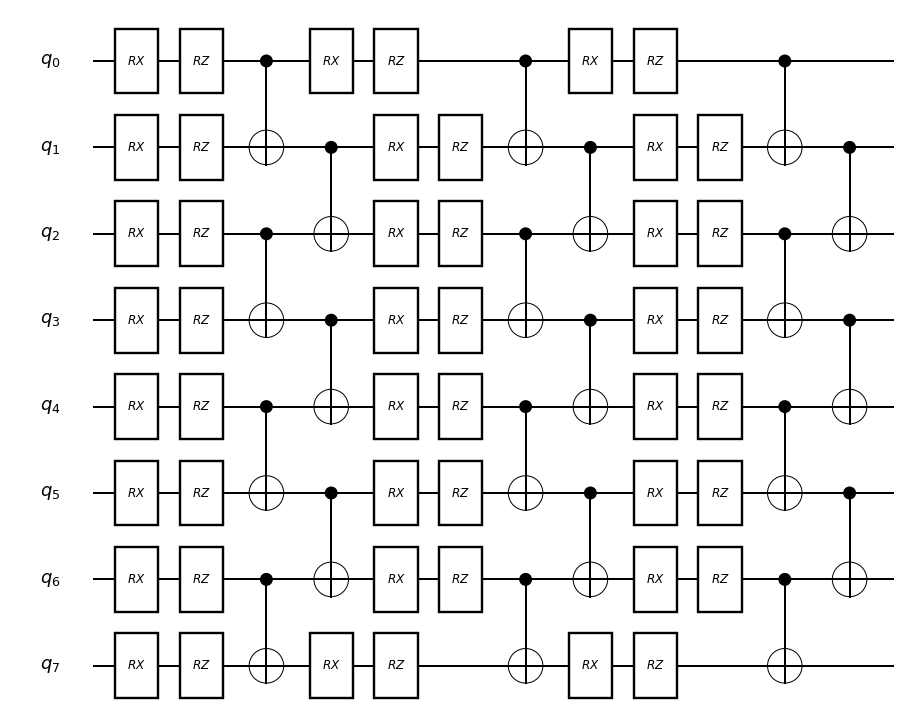

In [13]:
#本コードで利用しているansatzの構造を確認している
num_qubit = num_site

### layer数
rep_layer = 3

num_params_layer = num_qubit*2
num_params = num_params_layer * rep_layer

print('num site : '+str(num_site))
print('num_params_layer : '+str(num_params_layer))
print('num_params : '+str(num_params))

params_init = np.random.rand(num_params)*2*np.pi
circuit = make_ansatz_hea(parameters=params_init, num_qubit=num_qubit, num_params_layer=num_params_layer, rep_layer=rep_layer)
print(f'circuit depth : {circuit.calculate_depth()}')
circuit_drawer(circuit,'mpl')

num site : 8
num_params_layer : 16
num_params : 80
0 time
1 time
2 time
3 time
4 time
5 time
6 time
7 time
8 time
9 time
10 time
11 time
12 time
13 time
14 time
15 time
16 time
17 time
18 time
19 time
20 time
21 time
22 time
23 time
24 time
25 time
26 time
27 time
28 time
29 time
num of all qubits : 8
average energy : -23.960140678334085
minimum energy : -24.496049911642057
exact energy : -24.586275728865992
ratio : 0.9963302365019032


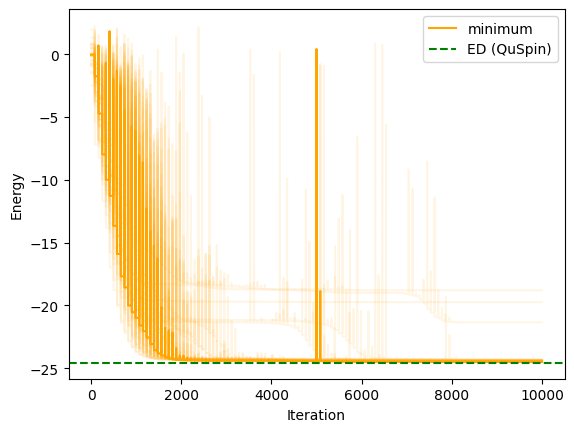

In [38]:
num_qubit = num_site

### ansatz内のlayerの繰り返し回数。上げるほど量子状態の表現能力が高まる。
rep_layer = 5

num_params_layer = num_qubit*2
num_params = num_params_layer * rep_layer
name = f'num_params_layer={num_params_layer}'

print('num site : '+str(num_site))
print('num_params_layer : '+str(num_params_layer))
print('num_params : '+str(num_params))

method = 'SLSQP'
num_trial = 30
maxiter = 10000
array_cost_hea = []
list_cost_hea_min = []
list_cost_hea_mean = []
list_cost_hea_std = []
for iter in range(num_trial):
    print(str(iter)+' time')
    list_cost_hea = []
    params_init = np.random.rand(num_params)*2*np.pi

    result = scipy.optimize.minimize(cost_hea, params_init, method=method, args=(num_qubit, num_params_layer, rep_layer, j_coup, h_ext))
    
    for i_cost in range(len(list_cost_hea), maxiter):
        list_cost_hea.append(list_cost_hea[-1])
    
    array_cost_hea.append(list_cost_hea)
    
    if(iter==0):        
        list_cost_hea_min = list_cost_hea
    else:
        if(sum(list_cost_hea_min[-11:-1])/10>sum(list_cost_hea[-11:-1])/10):
            list_cost_hea_min = list_cost_hea

array_cost_hea = np.array(array_cost_hea)
array_cost_hea = array_cost_hea
list_cost_hea_mean = array_cost_hea.mean(axis=0)
list_cost_hea_std = array_cost_hea.std(axis=0)
print('num of all qubits : '+str(num_qubit))
print('average energy : '+str(list_cost_hea_mean[-1]))
print('minimum energy : '+str(list_cost_hea_min[-1]))
print('exact energy : '+str(energy_quspin_open))
print("ratio : "+str(list_cost_hea_min[-1]/energy_quspin_open))
ite_cost_hea = list(range(len(list_cost_hea)))

for i_list in range(array_cost_hea.shape[0]):
    plt.plot(ite_cost_hea, array_cost_hea[i_list], alpha=0.1, color='orange')
plt.plot(ite_cost_hea, list_cost_hea_min, label='minimum', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.axhline(y=energy_quspin_open, xmin=0,xmax=80,ls='--',label='ED (QuSpin)',c='green')
plt.legend()
plt.show()